
# Assignment 4 
In this assignment you will be working with a character based LSTM language model, which you will turn into a text classifier for sentiment analysis using **Attention**. For that, you will need to develop the Attention mechanism that aggregates the hidden output vectors that you get per character into a single vector, which you will use as an input for a final linear classifier.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from random import sample
from IPython.display import clear_output

In [ ]:
!git clone https://github.com/kfirbar/course-ml-data.git

fatal: destination path 'course-ml-data' already exists and is not an empty directory.


The data that you will be working with is SST-2, which is a collection of reviews, each is classified into 0/1 reflecting the overall sentiment of the author (0 = negative, 1 = positive). In the next piece of code, we load the data and create a dictionary (named Vocab) that assigns a unique ID per character, similar to what have done in DL Notebook 12. Finally, each one of *train* and *dev* is a list of tuples, with the first item being the text encoded as character indices, and the second item is the label (0, 1).

In [ ]:
# We will work only with texts of size < 50 characters
MAX_SEQ_LEN = 50

class Vocab:
    def __init__(self):
        self.char2id = {}
        self.id2char = {}
        self.n_chars = 1
        
    def index_text(self, text):
      indexes = [self.index_char(c) for c in text]
      return indexes
    
    def index_char(self, c):
        if c not in self.char2id:
            self.char2id[c] = self.n_chars
            self.id2char[self.n_chars] = c
            self.n_chars += 1
        return self.char2id[c]
            
            
def load_data(data, vocab):
  data_sequences = []
  for text in data.iterrows():
    if len(text[1]["sentence"]) <= MAX_SEQ_LEN:
      indexes = vocab.index_text(text[1]["sentence"])
      data_sequences.append((indexes, text[1]["label"]))
  return data_sequences

vocab = Vocab()
train = load_data(pd.read_csv('/content/course-ml-data/SST2_train.tsv', sep='\t'), vocab)
dev = load_data(pd.read_csv('/content/course-ml-data/SST2_dev.tsv', sep='\t'), vocab)
print(f'Train size {len(train)}, Dev size {len(dev)}, vocab size {vocab.n_chars}')

Train size 40625, Dev size 119, vocab size 63


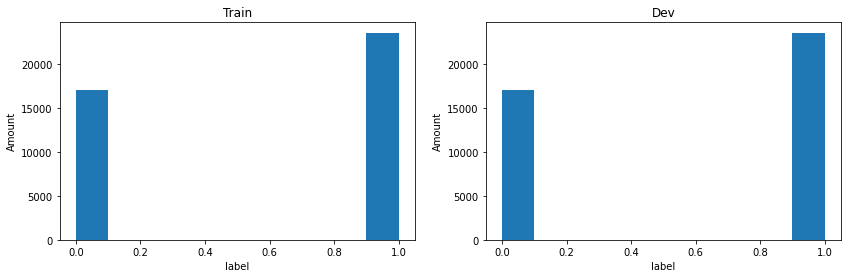

In [ ]:
train_labels = [l for (_,l) in train]
dev_labels   = [l for (_,l) in dev]

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.hist(train_labels)
plt.title('Train')
plt.ylabel('Amount')
plt.xlabel('label');

plt.subplot(1,2,2)
plt.hist(train_labels)
plt.title('Dev')
plt.ylabel('Amount')
plt.xlabel('label');

# Task 1
The following RNN architectures takes a single sentence as an input (formatted as a 1D tensor of character ids), and returns a distribution over the labels. In our case the number of labels is 2 (negative, positive). 

I basically copied the same architecture from Notebook 12, where each input character gets an output vector from the LSTM module, which are used to precdict the next character in line. However, here, we are not really interested in predicting the next character, but in aggregating all those output vectors into a single "context" vector, which will be sent to a Linear layer for the final classification step.

Therefore, you are requested to add the relevant code for aggregating the output vectors using the **additive attention** approach, following presentation *DL 14*. Note that some of what you need to add should be parameters, which you need to define under the __init__ function.


In [ ]:
class SeqModel(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size):
    super(SeqModel, self).__init__()
    self.embedding = torch.nn.Embedding(input_size, embedding_size)
    self.rnn = torch.nn.LSTM(embedding_size, hidden_size)
    
    # TODO: add the relevant initialization code for the Attention mechanism
    self.new_linear = torch.nn.Linear(hidden_size,hidden_size)
    self.V = torch.nn.parameter.Parameter(torch.nn.init.xavier_uniform_(torch.empty((1,hidden_size))))

    #  final FC layer
    self.out = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):

    # embedding
    x = self.embedding(x).view(len(x), 1, -1)
    
    # LSTM
    x, _  = self.rnn(x)
    x = x.squeeze(dim=1)

    # Attention
    alpha = self.new_linear(x)
    alpha = torch.tanh(alpha)
    alpha = torch.mul(alpha,self.V)
    alpha = torch.nn.functional.softmax(alpha,dim=1)
    
    # context
    context = torch.sum( x * alpha, dim=0)

    return torch.sigmoid(self.out(context)) 


# Task 2
Once completed, you are now requested to write some code for training the model using the following configuration. Make sure to print the training loss every 100 sentences so you can follow. Train your code for 4 epochs, and use cuda + GPU.

In [ ]:
# model
model = SeqModel(vocab.n_chars, 64, 300, 1).cuda()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Your training code goes here
n_epochs = 4
print_every = 1000
loss = []

for e in range(1, n_epochs + 1):
    clear_output(wait=True)

    loss_ = 0
    sentence_loss = 0
    shuff = sample(train, len(train))

    for counter,(sequence,label) in enumerate(shuff):

      optimizer.zero_grad()
      
      sequence = torch.tensor(sequence).cuda()
      label = torch.tensor(label).cuda()
      
      output = model(sequence)
      sentence_loss = criterion(output,label.unsqueeze(0).float())
      sentence_loss.backward()
      optimizer.step()

      loss_ += sentence_loss.item()
      
      if counter!=0 & (counter % print_every == 0) :
          loss_ = loss_ / print_every
          loss.append(loss_)
          print('Epoch %d, %d/%d, Current Loss = %f' % (e, counter, len(train), loss_))         
          loss_ = 0
      

Epoch 4, 0/40625, Current Loss = 0.000002
Epoch 4, 1000/40625, Current Loss = 0.294394
Epoch 4, 2000/40625, Current Loss = 0.299717
Epoch 4, 3000/40625, Current Loss = 0.329156
Epoch 4, 4000/40625, Current Loss = 0.307975
Epoch 4, 5000/40625, Current Loss = 0.332246
Epoch 4, 6000/40625, Current Loss = 0.324518
Epoch 4, 7000/40625, Current Loss = 0.337459
Epoch 4, 8000/40625, Current Loss = 0.319927
Epoch 4, 9000/40625, Current Loss = 0.333583
Epoch 4, 10000/40625, Current Loss = 0.343378
Epoch 4, 11000/40625, Current Loss = 0.337891
Epoch 4, 12000/40625, Current Loss = 0.310937
Epoch 4, 13000/40625, Current Loss = 0.352247
Epoch 4, 14000/40625, Current Loss = 0.350931
Epoch 4, 15000/40625, Current Loss = 0.326284
Epoch 4, 16000/40625, Current Loss = 0.298332
Epoch 4, 17000/40625, Current Loss = 0.313700
Epoch 4, 18000/40625, Current Loss = 0.335824
Epoch 4, 19000/40625, Current Loss = 0.341946
Epoch 4, 20000/40625, Current Loss = 0.346920
Epoch 4, 21000/40625, Current Loss = 0.334585
E

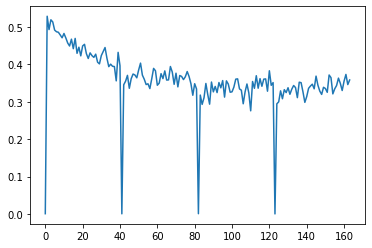

In [ ]:
plt.plot(loss)

# Task 3
Write some code for evaluating your model on the dev set. Since the data is almost balanced (there are 52 positives in the dev set), let's print accuracy (i.e., the number of correctly classified instances).

In [ ]:
# Your evalutation code goes here
with torch.no_grad():
    correct = 0
    total = 0
    for data in dev:
        dev_sentence, dev_label = data
        dev_sentence = torch.tensor(dev_sentence).cuda()

        outputs = model(dev_sentence)
        predicted = torch.round(outputs.data)
        total += 1 
        correct += (predicted == dev_label).sum().item()

    acc = 100.0 * correct / total
    print(f'Accuracy of the model: {acc} %')

Accuracy of the model: 85.71428571428571 %
